In this first box we're just simply importing in all of the modules that are being used and ensuring we are in the right directory to get our calibration files.

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
import os

cwd = os.getcwd()
if cwd[-5:] != "Lab_3":
    os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_3")

In this next box we're importing in all of the calibration files we're going to need for data reduction. We have dark frames specifically for merak (actually taken with a 2 min exposure) that we can also use for the flat fields and the lamp spectrum, and then the dark frames we use for the galaxies. We are also importing the flat field images so that we can subtract any dark current from it.

In [231]:
# Importing the dark frames that were taken for Merak

two_min_dark_prefix = "lab_3_dark_5_min.0000000"
two_min_dark_suffix = ".DARK.FIT"
two_min_dark_data = []
two_min_start = 0
two_min_end = 4

for i in range(two_min_start, two_min_end+1, 1):
    filename = two_min_dark_prefix + str(i) + two_min_dark_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    two_min_dark_data.append(image_data)
        
# Importing the dark frames that were taken for the galaxies and will be used on flat fields (same exposure times)        
gal_dark_prefix = "lab_3_dark_25_min.0000000"
gal_dark_suffix = ".DARK.FIT"
gal_dark_data = []
gal_start = 0
gal_end = 1

for i in range(gal_start, gal_end+1, 1):
    filename = gal_dark_prefix + str(i) + gal_dark_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    gal_dark_data.append(image_data)
        
# lamp_data = []
# with fits.open('calibration_images/lab_3_ne_lamp.00000000.FIT') as file:
#     plt.imshow(file[0].data, cmap='gray', vmax=9000)
#     plt.colorbar()
#     lamp_data.append(file[0].data)
    
    
# Importing the flat fields that were taken for our observations (same for all)
flat_prefix = "lab_3_flat_2_min.0000000"
flat_suffix = ".FIT"
flat_data = []
flat_start = 0
flat_end = 3

for i in range(flat_start, flat_end+1, 1):
    ind = str(i)
    filename = flat_prefix + str(i) + flat_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    flat_data.append(image_data)


Here we're just calculating the master dark frames for the 2 min and the 25 min dark frames. We're using the mean here rather than the median since there are not that many points to work with.

In [232]:
# Calculating the master dark frames for Merak and the Galaxies

two_min_master_dark = np.mean(two_min_dark_data, axis=0)
gal_master_dark = np.mean(gal_dark_data, axis=0)

In this box we're importing in all of the science images taken. Rather than having seperate sections to import in each set of images seperately, we are utilizing lists to open specified files in specified directories. We save each set of images within the list `total_data`, with each index representing each group of images. So `total_data[0]` refers to the merak images, and `total_data[0][0]` refers to the first image in the group of merak images.

In [233]:
names = ["lab_3_merak_2_mins.0000000", "lab_3_m51_25_min.0000000", "lab_3_m82_25_mins.0000000", "lab_3_ne_lamp.0000000", "lab_3_empty_25_mins.0000000"]
folder_names = ["merak_images", "m51_images", "m82_images", "calibration_images", "calibration_images"]

starts = [0, 1, 0, 0, 3]
ends = [4, 3, 2, 0, 5]
image_end = ".FIT"
melark_data = []
m51_data = []
m82_data = []
lamp_data = []
sky_data = []
total_data = [melark_data, m51_data, m82_data, lamp_data, sky_data]

j = 0
for image_prefix in names:
    for i in range(starts[j], ends[j]+1, 1):
        filename = image_prefix + str(i) + image_end
        list = fits.open(folder_names[j]+"/"+filename)
        image_data = list[0].data
        total_data[j].append(image_data)
    j += 1  

# print(min(total_data[1][0].flatten()))
# x = np.linspace(0, len(total_data[1][0].flatten()), num=len(total_data[1][0].flatten()))
# plt.plot(x, total_data[1][0].flatten())

# for i in range(len(total_data[1])):
#     x = np.linspace(0, len(total_data[1][i].flatten()), num=len(total_data[1][i].flatten()))
#     plt.plot(x, total_data[1][i].flatten())
#     plt.show()
    

Now we're taking our data and subtracting out the dark current for each image. The merak and lamp images correspond to `total_data[0]` and `total_data[3]`. So when we subtract from those in our loop we ensure we're using the two minute dark frame, while for the rest we subtract the 25 minute dark frame, i.e. `gal_master_dark`. We save the calibrated data in the list `calib_totals`.

We then separate `calib_totals` into the respective groups and also subtract the dark current from out flat field images as well. We also create a "master sky" image by using both the mean values and the median values. For all of the values in the two master sky images, if the value is less than 0.0 we set the value equal to the mean/median value. **We haven't done this for the individual science images yet, and we are unsure if we should be doing that or not.**

Finally we subtract the sky images from our calibrated sky images, using both the mean sky image and the median sky image seperately.

In [234]:
calib_totals = []
merak_final = []
m51_final = []
m82_final = []
lamp_final = []
sky_final = []

for j in range(0, 5):
    for i in range(0, len(total_data[j])):
        if j == 0 or j == 3:
            calib_totals.append(total_data[j][i]-two_min_master_dark)
        else:
            calib_totals.append(total_data[j][i]-gal_master_dark)

for i in range(0, len(calib_totals)):
    for j in range(0, 255):
        for k in range(0, 765):
            if calib_totals[i][j][k] < -500.:
                calib_totals[i][j][k] = np.median(calib_totals[i].flatten())

merak_final = calib_totals[0:5]
m51_final = calib_totals[5:8]
m82_final = calib_totals[8:11]
lamp_final = calib_totals[11:12]
sky_final = calib_totals[12:]
flat_final = flat_data - two_min_master_dark


sky_median = [np.median(sky_final, axis=0)]
sky_mean = [np.mean(sky_final, axis=0)]
total_sky_median = np.median(sky_median[0].flatten())
total_sky_mean = np.mean(sky_mean[0].flatten())

for i in range(0, 255):
    for j in range(0, 765):
        if sky_median[0][i][j] < 0.0:      
            sky_median[0][i][j] = total_sky_median
        if sky_mean[0][i][j] < 0.0:
            sky_mean[0][i][j] = total_sky_mean

merak_final_med = [merak_final[x] - (sky_median[0])/12.5 for x in range(0, len(merak_final))]
merak_final_mean = [merak_final[x] - (sky_mean[0])/12.5 for x in range(0, len(merak_final))]
m51_final_med = [m51_final[x] - sky_median for x in range(0, len(m51_final))]
m51_final_mean = [m51_final[x] - sky_mean for x in range(0, len(m51_final))]
m82_final_med = [m82_final[x] - sky_median for x in range(0, len(m82_final))]
m82_final_mean = [m82_final[x] - sky_mean for x in range(0, len(m82_final))]

# print(min(m51_final_med[0].flatten()))

# x = np.linspace(0, len(two_min_master_dark.flatten()), num=len(two_min_master_dark.flatten()))
# plt.plot(x, two_min_master_dark.flatten())
# plt.title("2 Minute Dark Frame Counts")
# plt.show()
# plt.title("Final Data for one m51 Image")
# plt.plot(x, m51_final_med[0].flatten())

# titles = ["Merak", "M51", "M82", "Lamp", "Sky"]
# for i in range(0, 15):
#     if i in range(0, 5):
#         k = 0
#     elif i in range(5, 8):
#         k=1
#     elif i in range(8, 11):
#         k=2
#     elif i == 11:
#         k=3
#     elif i >= 12:
#         k=4
#     title = titles[k]
#     x = np.linspace(0, len(calib_totals[i].flatten()), num=len(calib_totals[i].flatten()))
#     plt.plot(x, calib_totals[i].flatten())
#     plt.title(title)
#     plt.show()


Now we're switching directories into our **calibrated_fits_files** directory where we will be putting our calibrated files. We once again do this through the use of lists.

In [235]:
cwd = os.getcwd()
if cwd[-25:] != "calibrated_fits_files":
    os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_3/calibrated_fits_files")
    cwd = os.getcwd()
target_names = ["merak_med.00", "merak_mean.00", "m51_med.00", "m51_mean.00", "m82_med.00", "m82_mean.00", "neon.00", "sky.00", "sky_med.00", "sky_mean.00", "flat.00"]
data = [merak_final_med, merak_final_mean, m51_final_med, m51_final_mean, m82_final_med, m82_final_mean, lamp_final, sky_final, sky_median, sky_mean, flat_data]
j=0
if os.path.exists("merak_med.000.FIT") == True:
    for image_prefix in target_names:
        image_suffix = ".FIT"
        for i in range(0, len(data[j])):
            hdu = fits.PrimaryHDU(data[j][i])
            filename = image_prefix + str(i) + image_suffix
            hdu.writeto(filename, overwrite=True)
        j += 1
        
# for j in range(0, len(data)):  
#     for i in range(0, len(data[j])):
#         x = np.linspace(0, len(data[j][i].flatten()), num=len(data[j][i].flatten()))
#         plt.plot(x, data[j][i].flatten())
#         plt.show()

We're just using this to plot images to see how they look after we saved them.

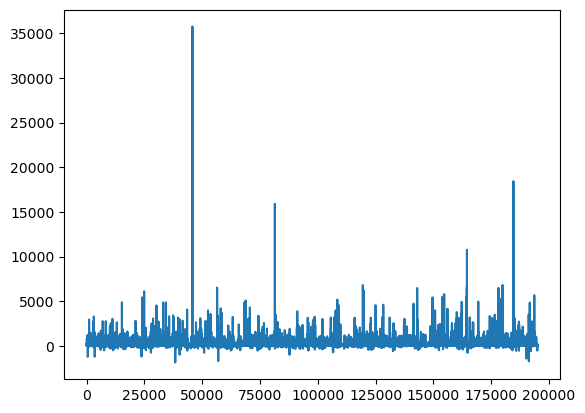

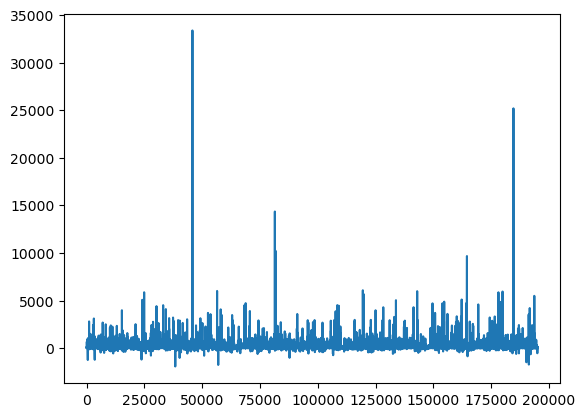

In [236]:
with fits.open('m82_mean.000.FIT') as file:
    data = file[0].data
    flat_data = data.flatten()
    x = np.linspace(0, len(flat_data), num=len(flat_data))
    plt.plot(x, flat_data)
    plt.show()

with fits.open('m82_mean.002.FIT') as file:
    data = file[0].data
    flat_data = data.flatten()
    x = np.linspace(0, len(flat_data), num=len(flat_data))
    plt.plot(x, flat_data)